# Import packages 

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import requests
import time 
import os
import pandas as pd

chromedriver = "/Applications/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver

In [2]:
url = 'https://www.udemy.com/courses/marketing/'
page = requests.get(url).text
soup = BeautifulSoup(page, 'lxml')
driver = webdriver.Chrome(executable_path=chromedriver)
driver.get(url)

# Perform web Scraping 

In [3]:
def extract_record(item):
    try :
        title = item.find('div',{'class':'udlite-focus-visible-target udlite-heading-md course-card--course-title--vVEjC'}).text
    except :
        title = None
    try :
        description = item.find('p',{'class':'udlite-text-sm course-card--course-headline--2DAqq'}).text
    except :
        description = None
    try :
        price = item.find('div', {'class':'price-text--price-part--2npPm course-card--discount-price--1bQ5Q udlite-heading-md'}).text 
    except :
        price = None
    try :
        rating = item.find('span',{'class':'star-rating--star-wrapper--1QyBg'}).find('span').text
    except :
        rating = None
    try :
        reviews = item.find('span',{'class':'udlite-text-xs course-card--reviews-text--1yloi'}).text
    except :
        reviews = None
    
    if item.find('s') == None :
        discount = None
    else :
        discount = item.find('s').find('span').text
    try :
        trainer = item.find('div',{'class':'udlite-text-xs course-card--instructor-list--nH1OC'}).text
    except :
        trainer = None
    course_info = item.find('div',{'class':'udlite-text-xs course-card--row--29Y0w course-card--course-meta-info--2jTzN'}).find_all('span')
    
    if len(course_info) == 3 :
        total_hours = course_info[0].text
        total_lectures = course_info[1].text
        level = course_info[2].text
    else :
        total_hours = None
        total_lectures = None
        try:
            level = course_info[1].text
        except :
            level = None
    
    result = (title,description,price,rating,reviews,discount,trainer,total_hours,total_lectures,level) 
    
    
    return result

In [5]:
def get_data() :
    records=[]

    for i in range(1,600):
        url = 'https://www.udemy.com/courses/marketing/?p='+str(i)

        print(url)
        driver.get(url)
        time.sleep(5)
        soup = BeautifulSoup(driver.page_source, "html5lib")

       
        div = soup.find(class_='course-list--container--3zXPS')
        results = div.find_all('a',{'class':'udlite-custom-focus-visible browse-course-card--link--3KIkQ'})
        
        
        
        for item in results:
            records.append(extract_record(item))
        time.sleep(5)
        
    return records
    

In [5]:
records = get_data()

# Definig the data frame 

In [7]:
df = pd.DataFrame(records, columns=['title','description','price','rating','reviews',
                                    'discount','trainer','total_hours','total_lectures',
                                    'level'])

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7684 entries, 0 to 9899
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           7684 non-null   object 
 1   description     7684 non-null   object 
 2   price           7684 non-null   float64
 3   rating          7684 non-null   float64
 4   reviews         7684 non-null   int64  
 5   discount        7684 non-null   float64
 6   trainer         7683 non-null   object 
 7   total_hours     7684 non-null   float64
 8   total_lectures  7684 non-null   int64  
 9   level           7684 non-null   object 
dtypes: float64(4), int64(2), object(4)
memory usage: 660.3+ KB


In [6]:
df = pd.read_csv('udemy_data_9k.csv')

# Data cleaning 

In [7]:
df.columns

Index(['Unnamed: 0', 'title', 'description', 'price', 'rating', 'reviews',
       'discount', 'trainer', 'total_hours', 'total_lectures', 'level'],
      dtype='object')

In [8]:
df.drop(columns="Unnamed: 0",inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9904 entries, 0 to 9903
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           9904 non-null   object
 1   description     9903 non-null   object
 2   price           9833 non-null   object
 3   rating          9904 non-null   object
 4   reviews         9904 non-null   object
 5   discount        9289 non-null   object
 6   trainer         9904 non-null   object
 7   total_hours     8229 non-null   object
 8   total_lectures  8229 non-null   object
 9   level           9904 non-null   object
dtypes: object(10)
memory usage: 773.9+ KB


In [10]:
df.dropna(inplace=True)

In [11]:
df.trainer = df.trainer.str.replace(',','')

In [12]:
df.trainer = df.trainer.str.split().str[0] +' '+ df.trainer.str.split().str[1]

In [13]:
import re
def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return "".join(num)
def find_rating(text):
    num = re.findall(r'[0-9]+',text)
    num.pop()
    return ".".join(num)

In [14]:
df.reviews = df['reviews'].apply(lambda x: find_number(x)).astype(int)

In [15]:
df.rating = df['rating'].apply(lambda x: find_rating(x)).astype(float)

In [16]:
df.total_hours = df['total_hours'].str.extract(r'(\d+.\d*)').astype('float')

In [17]:
df.discount = df['discount'].str.extract(r'(\d+.\d*)').astype('float')

In [18]:
df.total_lectures = df['total_lectures'].apply(lambda x: find_number(x)).astype(int)

In [19]:
df.price = df['price'].str.extract(r'(\d+.\d*)').astype('float')

In [20]:
df.level.unique()

array(['All Levels', 'Beginner', 'Intermediate', 'Expert'], dtype=object)

In [21]:
df.to_csv('cleaned_udemy_data_9k.csv')

In [22]:
df

,title,description,price,rating,reviews,discount,trainer,total_hours,total_lectures,level
0,Learn Ethical Hacking From Scratch,Become an ethical hacker that can hack compute...,17.99,4.6,98659,99.99,Zaid Sabih,15.5,143,All Levels
1,Ultimate AWS Certified Solutions Architect Ass...,Pass the AWS Certified Solutions Architect Ass...,15.99,4.7,95644,89.99,Stephane Maarek,27.0,368,All Levels
2,[NEW] Ultimate AWS Certified Cloud Practitione...,Pass the Amazon Web Services Certified Cloud P...,14.99,4.7,61639,84.99,Stephane Maarek,14.0,252,Beginner
3,TOTAL: CompTIA A+ Certification (220-1001).,Course 1: Everything you need to pass the A+ C...,20.99,4.7,48503,119.99,Total Seminars,17.5,131,Beginner
4,Ultimate AWS Certified Developer Associate 202...,Become an AWS Certified Developer! Learn all A...,14.99,4.7,47458,89.99,Stephane Maarek,32.5,428,All Levels
...,...,...,...,...,...,...,...,...,...,...
9891,Reverse Engineering Deep Dive,"Deobfuscations, disassembly, shellcode analysi...",14.99,3.6,7,89.99,Cristina Gheorghisan,6.0,36,Intermediate
9892,Achieving NSA level privacy,This course will help you to be totally anonym...,14.99,5.0,7,49.99,Lakshay arora,1.0,16,All Levels
9896,Migrating a DFS-R Deployment to Azure File Sync,How to Deploy Azure File Sync and Migrate from...,14.99,4.5,7,19.99,Thomas Mitchell,1.0,18,Intermediate
9897,Internet of Things (IoT) Fundamentals Certific...,Become an IoT Engineer / Product Manager. Lear...,14.99,3.2,7,19.99,Uplatz Training,11.0,17,All Levels


# Visualization

In [23]:
import seaborn as sns

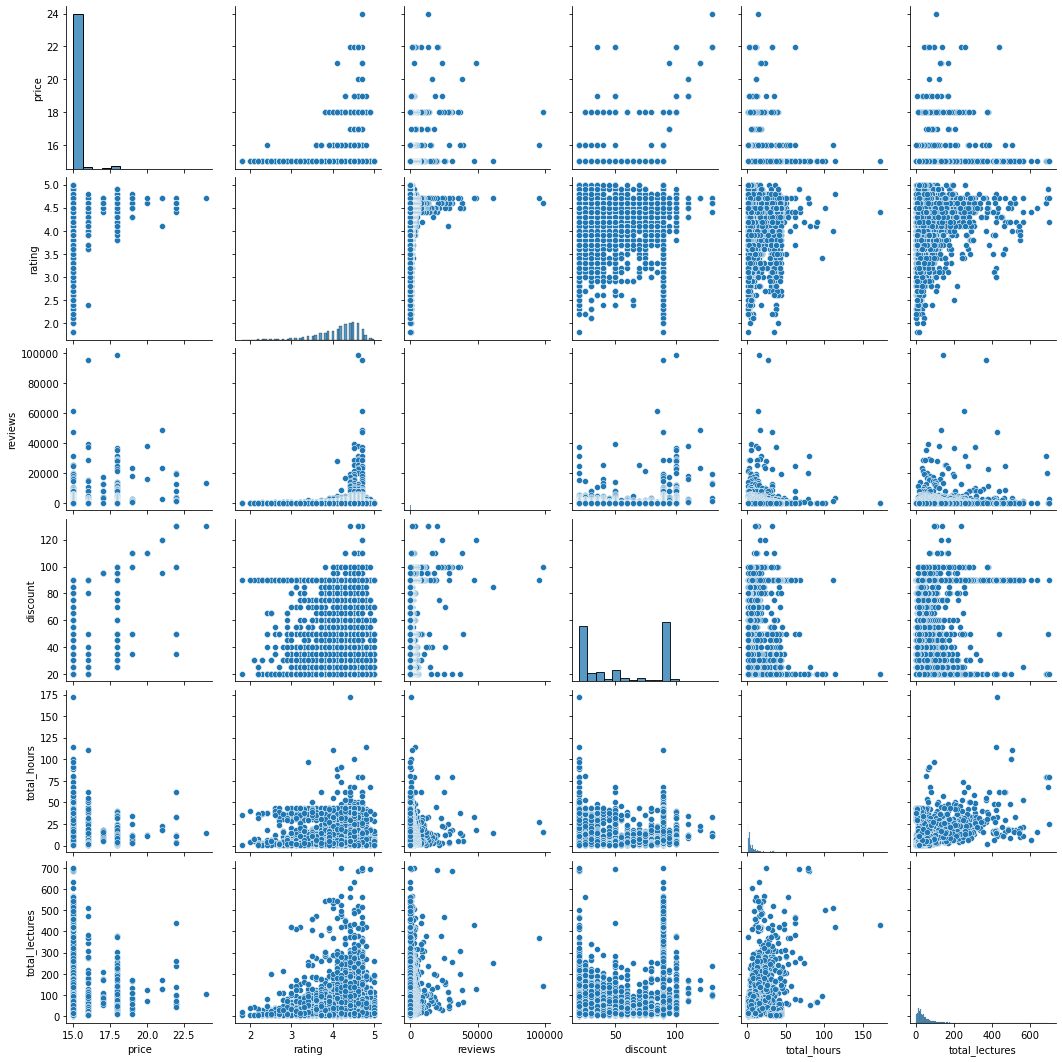

In [24]:
sns.pairplot(df)